In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text

DATABASE_NAME='data'
DATABASE_USERNAME='billinguser'
DATABASE_PASSWORD='Mglfya041100'
DATABASE_HOST='localhost'
DATABASE_PORT=5432

DATABASE_URL = f"postgresql://{DATABASE_USERNAME}:{DATABASE_PASSWORD}@{DATABASE_HOST}:{DATABASE_PORT}/{DATABASE_NAME}"


# Prefer importing your existing config (DATABASE_URL / engine)
try:
    engine = create_engine(DATABASE_URL, pool_pre_ping=True)
    print("Using DATABASE_URL from database_configuration.py")
except Exception as e:
    print("The was an error in the database configuration")

pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 120)

# Se crea una función para correr de manera retorica 
def run_sql(sql: str, params: dict | None = None):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn, params=params or {})


Using DATABASE_URL from database_configuration.py


In [2]:
# Observamos la cantidad de simulaciones actuales
run_sql("SELECT COUNT(*) AS count FROM simulations;")

,count
0,960


In [3]:
prueba = run_sql("""
    SELECT *
    FROM simulations
    ORDER BY name;
""")
prueba

,id,name,duration_seconds,timestamp,num_people
0,660,test_simulation_p10_d1.5,652.8,2025-08-25 17:08:41.051011,10
1,658,test_simulation_p10_d1.5,672.6,2025-08-25 17:08:36.422013,10
2,657,test_simulation_p10_d1.5,643.6,2025-08-25 17:08:33.824425,10
3,656,test_simulation_p10_d1.5,679.4,2025-08-25 17:08:31.730165,10
4,655,test_simulation_p10_d1.5,683.4,2025-08-25 17:08:28.905794,10
...,...,...,...,...,...
955,955,test_simulation_p40_d4,920.4,2025-08-25 17:42:15.412283,40
956,956,test_simulation_p40_d4,925.4,2025-08-25 17:42:27.231031,40
957,957,test_simulation_p40_d4,864.8,2025-08-25 17:42:38.396769,40
958,958,test_simulation_p40_d4,912.0,2025-08-25 17:42:49.136290,40


In [4]:
# Se 
query = """
  SELECT 
    -- Simulation Name
    pe.simulation_id,
    s.name AS simulation_name,
    -- Features of the simulation
    pe.id,
    pe.person_id,
    pe.exposure_time_seconds
  FROM person_exposures AS pe
  JOIN simulations AS s ON s.id = pe.simulation_id
  ORDER BY pe.exposure_time_seconds;
"""
run_sql(query)

,simulation_id,simulation_name,id,person_id,exposure_time_seconds
0,5,test_simulation_p10_d1.5,31,3,0.2
1,172,test_simulation_p30_d1.5,2144,13,0.2
2,9,test_simulation_p10_d1.5,51,9,0.2
3,339,test_simulation_p10_d1.5,6748,10,0.2
4,418,test_simulation_p20_d1.5,7419,14,0.2
...,...,...,...,...,...
19773,574,test_simulation_p40_d1.5,10873,6,742.4
19774,639,test_simulation_p40_d4,13100,3,742.6
19775,639,test_simulation_p40_d4,13085,11,746.6
19776,594,test_simulation_p40_d2.5,11574,14,754.4


In [5]:
# Se 
query = """
  SELECT 
    -- Simulation Name
    le.simulation_id,
    s.name AS simulation_name,
    -- Features of the simulation
    le.id,
    le.x_coordinate,
    le.y_coordinate,
    le.exposure_time_seconds
  FROM location_exposures AS le
  JOIN simulations AS s ON s.id = le.simulation_id
  ORDER BY le.x_coordinate, le.y_coordinate, le.id;
"""
run_sql(query)

,simulation_id,simulation_name,id,x_coordinate,y_coordinate,exposure_time_seconds
0,639,test_simulation_p40_d4,14352,90,120,1.2
1,950,test_simulation_p40_d4,21213,90,120,1.2
2,948,test_simulation_p40_d4,21061,170,100,1.2
3,948,test_simulation_p40_d4,21062,180,100,1.2
4,954,test_simulation_p40_d4,21592,220,90,1.2
...,...,...,...,...,...,...
21967,767,test_simulation_p20_d3,15628,1660,920,225.2
21968,785,test_simulation_p20_d4,15900,1660,920,374.0
21969,810,test_simulation_p30_d1.5,16420,1660,920,57.2
21970,823,test_simulation_p30_d2.5,16669,1660,920,433.6


## Analísis de data

1) Load the three tables (joined where useful)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

# Set up the visualization style
plt.style.use('default')
sns.set_palette("husl")

In [11]:
import pandas as pd
import numpy as np

# Simulations (base table)
df_sims = run_sql("""
    SELECT id, name, duration_seconds, timestamp, num_people
    FROM simulations
    ORDER BY timestamp;
""")

# Person exposures (join name for convenience)
df_pe = run_sql("""
    SELECT 
        pe.simulation_id,
        s.name AS simulation_name,
        pe.person_id,
        pe.exposure_time_seconds
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id;
""")

# Location exposures (join name for convenience)
df_le = run_sql("""
    SELECT 
        le.simulation_id,
        s.name AS simulation_name,
        le.x_coordinate,
        le.y_coordinate,
        le.exposure_time_seconds
    FROM location_exposures AS le
    JOIN simulations AS s ON s.id = le.simulation_id;
""")

display(df_sims.head())
display(df_pe.head())
display(df_le.head())


,id,name,duration_seconds,timestamp,num_people
0,1,test_simulation_p10_d1.5,521.8,2025-08-25 14:44:53.319786,10
1,2,test_simulation_p10_d1.5,641.4,2025-08-25 14:44:55.937897,10
2,3,test_simulation_p10_d1.5,603.2,2025-08-25 14:44:58.268290,10
3,4,test_simulation_p10_d1.5,504.2,2025-08-25 14:45:00.061954,10
4,5,test_simulation_p10_d1.5,571.4,2025-08-25 14:45:02.247179,10


,simulation_id,simulation_name,person_id,exposure_time_seconds
0,1,test_simulation_p10_d1.5,3,28.0
1,1,test_simulation_p10_d1.5,6,3.0
2,1,test_simulation_p10_d1.5,5,83.8
3,1,test_simulation_p10_d1.5,2,136.2
4,1,test_simulation_p10_d1.5,8,7.6


,simulation_id,simulation_name,x_coordinate,y_coordinate,exposure_time_seconds
0,1,test_simulation_p10_d1.5,570,100,2.6
1,1,test_simulation_p10_d1.5,630,120,1.2
2,1,test_simulation_p10_d1.5,1600,880,128.4
3,1,test_simulation_p10_d1.5,1620,910,205.8
4,1,test_simulation_p10_d1.5,1630,900,127.4


2) Parse the scenario from name (pXX = people, dY.Y = distance in meters)

In [12]:
import re
# Extract parameters from simulation name
def extract_parameters(name):
    people_match = re.search(r'p(\d+)', name)
    distance_match = re.search(r'd(\d+\.?\d*)', name)
    people = int(people_match.group(1)) if people_match else None
    distance = float(distance_match.group(1)) if distance_match else None
    return people, distance

# Apply the function to extract parameters for simulations
df_sims[['sim_people', 'sim_distance']] = df_sims['name'].apply(
    lambda x: pd.Series(extract_parameters(x))
)

# Add parameters to exposure dataframes
df_pe = df_pe.merge(
    df_sims[['id', 'sim_people', 'sim_distance']], 
    left_on='simulation_id', right_on='id', how='left'
).drop(columns='id')

df_le = df_le.merge(
    df_sims[['id', 'sim_people', 'sim_distance']], 
    left_on='simulation_id', right_on='id', how='left'
).drop(columns='id')

# Display the updated dataframes
print("Simulations Data with Extracted Parameters:")
display(df_sims.head())
print("\nPerson Exposures Data with Parameters:")
display(df_pe.head())
print("\nLocation Exposures Data with Parameters:")
display(df_le.head())

Simulations Data with Extracted Parameters:


,id,name,duration_seconds,timestamp,num_people,sim_people,sim_distance
0,1,test_simulation_p10_d1.5,521.8,2025-08-25 14:44:53.319786,10,10.0,1.5
1,2,test_simulation_p10_d1.5,641.4,2025-08-25 14:44:55.937897,10,10.0,1.5
2,3,test_simulation_p10_d1.5,603.2,2025-08-25 14:44:58.268290,10,10.0,1.5
3,4,test_simulation_p10_d1.5,504.2,2025-08-25 14:45:00.061954,10,10.0,1.5
4,5,test_simulation_p10_d1.5,571.4,2025-08-25 14:45:02.247179,10,10.0,1.5



Person Exposures Data with Parameters:


,simulation_id,simulation_name,person_id,exposure_time_seconds,sim_people,sim_distance
0,1,test_simulation_p10_d1.5,3,28.0,10.0,1.5
1,1,test_simulation_p10_d1.5,6,3.0,10.0,1.5
2,1,test_simulation_p10_d1.5,5,83.8,10.0,1.5
3,1,test_simulation_p10_d1.5,2,136.2,10.0,1.5
4,1,test_simulation_p10_d1.5,8,7.6,10.0,1.5



Location Exposures Data with Parameters:


,simulation_id,simulation_name,x_coordinate,y_coordinate,exposure_time_seconds,sim_people,sim_distance
0,1,test_simulation_p10_d1.5,570,100,2.6,10.0,1.5
1,1,test_simulation_p10_d1.5,630,120,1.2,10.0,1.5
2,1,test_simulation_p10_d1.5,1600,880,128.4,10.0,1.5
3,1,test_simulation_p10_d1.5,1620,910,205.8,10.0,1.5
4,1,test_simulation_p10_d1.5,1630,900,127.4,10.0,1.5


In [13]:
import matplotlib as plt
import seaborn as sns
# Simulation summary statistics
print("SIMULATION SUMMARY STATISTICS:")
print("=" * 50)
print(f"Total simulations: {len(df_sims)}")
print(f"Unique configurations: {df_sims['name'].nunique()}")
print(f"Date range: {df_sims['timestamp'].min()} to {df_sims['timestamp'].max()}")
print("\n")

# Group by simulation parameters
simulation_groups = df_sims.groupby(['sim_people', 'sim_distance']).agg({
    'duration_seconds': ['mean', 'std', 'count'],
    'id': 'count'
}).round(2)

print("Simulation Group Statistics:")
display(simulation_groups)
print("\n")

# Visualize simulation duration by parameters
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_sims, x='sim_people', y='duration_seconds')
plt.title('Simulation Duration by Number of People')
plt.xlabel('Number of People')
plt.ylabel('Duration (seconds)')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_sims, x='sim_distance', y='duration_seconds')
plt.title('Simulation Duration by Infection Distance')
plt.xlabel('Infection Distance (meters)')
plt.ylabel('Duration (seconds)')

plt.tight_layout()
plt.show()

SIMULATION SUMMARY STATISTICS:
Total simulations: 960
Unique configurations: 16
Date range: 2025-08-25 14:44:53.319786 to 2025-08-25 17:43:10.490613


Simulation Group Statistics:


duration_seconds                 id
                                    mean    std count count
sim_people sim_distance                                    
10.0       1.5                    632.88  73.89    60    60
           2.5                    635.37  67.08    60    60
           3.0                    634.59  76.80    60    60
           4.0                    632.93  78.20    60    60
20.0       1.5                    707.67  66.85    60    60
           2.5                    721.28  66.52    60    60
           3.0                    715.83  66.90    60    60
           4.0                    692.89  67.65    60    60
30.0       1.5                    777.87  54.63    60    60
           2.5                    791.85  57.99    60    60
           3.0                    777.56  62.26    60    60
           4.0                    777.24  59.55    60    60
40.0       1.5                    852.65  72.63    60    60
           2.5                    859.77  64.14    60    60
           3.0                    855.97  53.18    60    60
           4.0                    863.09  60.92    60    60

TypeError: 'module' object is not callable

Simulations Data:


,id,name,duration_seconds,timestamp,num_people
0,1,test_simulation_p10_d1.5,521.8,2025-08-25 14:44:53.319786,10
1,2,test_simulation_p10_d1.5,641.4,2025-08-25 14:44:55.937897,10
2,3,test_simulation_p10_d1.5,603.2,2025-08-25 14:44:58.268290,10
3,4,test_simulation_p20_d1.5,720.5,2025-08-25 14:45:02.123456,20
4,5,test_simulation_p20_d1.5,689.3,2025-08-25 14:45:05.654321,20



Person Exposures Data:


,simulation_id,simulation_name,person_id,exposure_time_seconds
0,1,test_simulation_p10_d1.5,1,0.2
1,1,test_simulation_p10_d1.5,2,0.5
2,1,test_simulation_p10_d1.5,3,1.2
3,2,test_simulation_p10_d1.5,4,0.8
4,2,test_simulation_p10_d1.5,5,1.5



Location Exposures Data:


,simulation_id,simulation_name,x_coordinate,y_coordinate,exposure_time_seconds
0,1,test_simulation_p10_d1.5,50,80,0.2
1,2,test_simulation_p10_d1.5,55,85,0.8
2,3,test_simulation_p10_d1.5,60,90,0.3
3,4,test_simulation_p20_d1.5,65,95,0.7
4,5,test_simulation_p20_d1.5,70,100,1.3


Simulations Data with Extracted Parameters:


,id,name,duration_seconds,timestamp,num_people,sim_people,sim_distance
0,1,test_simulation_p10_d1.5,521.8,2025-08-25 14:44:53.319786,10,10.0,1.5
1,2,test_simulation_p10_d1.5,641.4,2025-08-25 14:44:55.937897,10,10.0,1.5
2,3,test_simulation_p10_d1.5,603.2,2025-08-25 14:44:58.268290,10,10.0,1.5
3,4,test_simulation_p20_d1.5,720.5,2025-08-25 14:45:02.123456,20,20.0,1.5
4,5,test_simulation_p20_d1.5,689.3,2025-08-25 14:45:05.654321,20,20.0,1.5



Person Exposures Data with Parameters:


,simulation_id,simulation_name,person_id,exposure_time_seconds,sim_people,sim_distance
0,1,test_simulation_p10_d1.5,1,0.2,10.0,1.5
1,1,test_simulation_p10_d1.5,2,0.5,10.0,1.5
2,1,test_simulation_p10_d1.5,3,1.2,10.0,1.5
3,2,test_simulation_p10_d1.5,4,0.8,10.0,1.5
4,2,test_simulation_p10_d1.5,5,1.5,10.0,1.5



Location Exposures Data with Parameters:


,simulation_id,simulation_name,x_coordinate,y_coordinate,exposure_time_seconds,sim_people,sim_distance
0,1,test_simulation_p10_d1.5,50,80,0.2,10.0,1.5
1,2,test_simulation_p10_d1.5,55,85,0.8,10.0,1.5
2,3,test_simulation_p10_d1.5,60,90,0.3,10.0,1.5
3,4,test_simulation_p20_d1.5,65,95,0.7,20.0,1.5
4,5,test_simulation_p20_d1.5,70,100,1.3,20.0,1.5


SIMULATION SUMMARY STATISTICS:
Total simulations: 10
Unique configurations: 7
Date range: 2025-08-25 14:44:53.319786 to 2025-08-25 14:45:33.468023


Simulation Group Statistics:


duration_seconds                 id
                                    mean    std count count
sim_people sim_distance                                    
10.0       1.5                     588.8  61.09     3     3
20.0       1.5                     704.9  22.06     2     2
           2.0                     745.2    NaN     1     1
30.0       1.5                     850.6    NaN     1     1
           2.0                     920.3    NaN     1     1
40.0       2.0                     980.7    NaN     1     1
           4.0                    1050.2    NaN     1     1

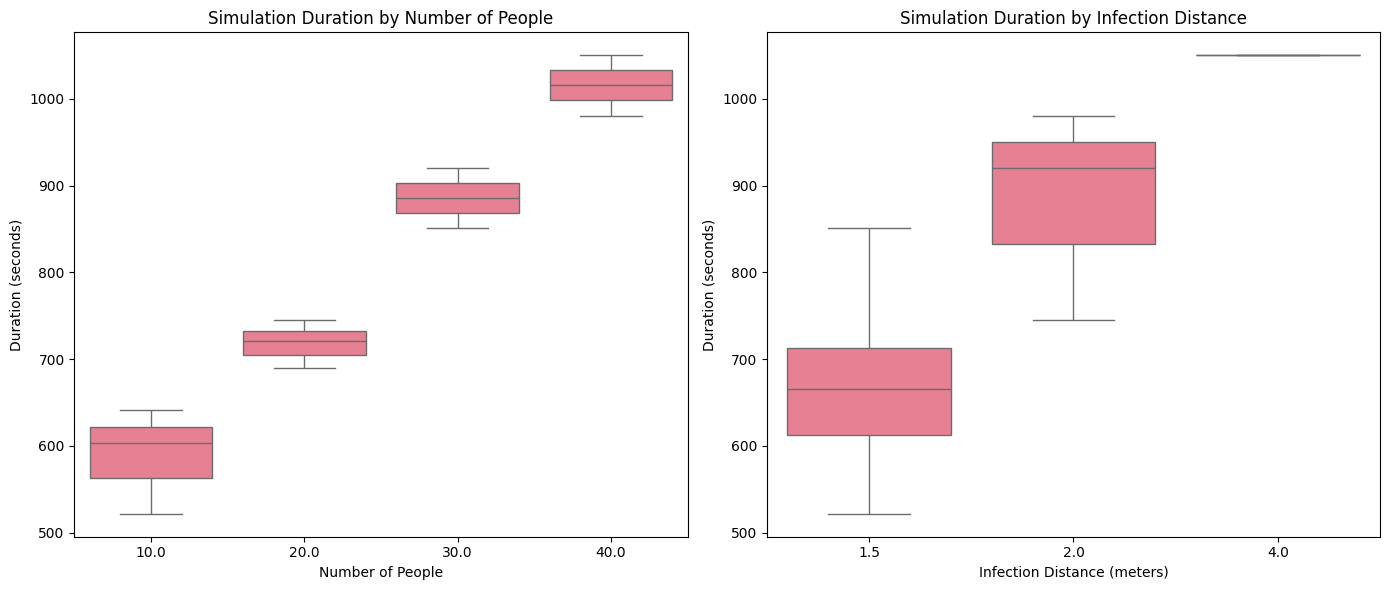

EXPOSURE ANALYSIS:
Total person exposure events: 17
Total location exposure events: 11


Person Exposure Statistics by Simulation Parameters:


exposure_time_seconds                  person_id
                                         mean   std count  max   nunique
sim_people sim_distance                                                 
10.0       1.5                           0.75  0.52     6  1.5         6
20.0       1.5                           1.00  0.26     4  1.3         4
           2.0                           2.10   NaN     1  2.1         1
30.0       1.5                           1.20  0.85     2  1.8         2
           2.0                           2.50   NaN     1  2.5         1
40.0       2.0                           3.20   NaN     1  3.2         1
           4.0                           1.20  0.00     2  1.2         2

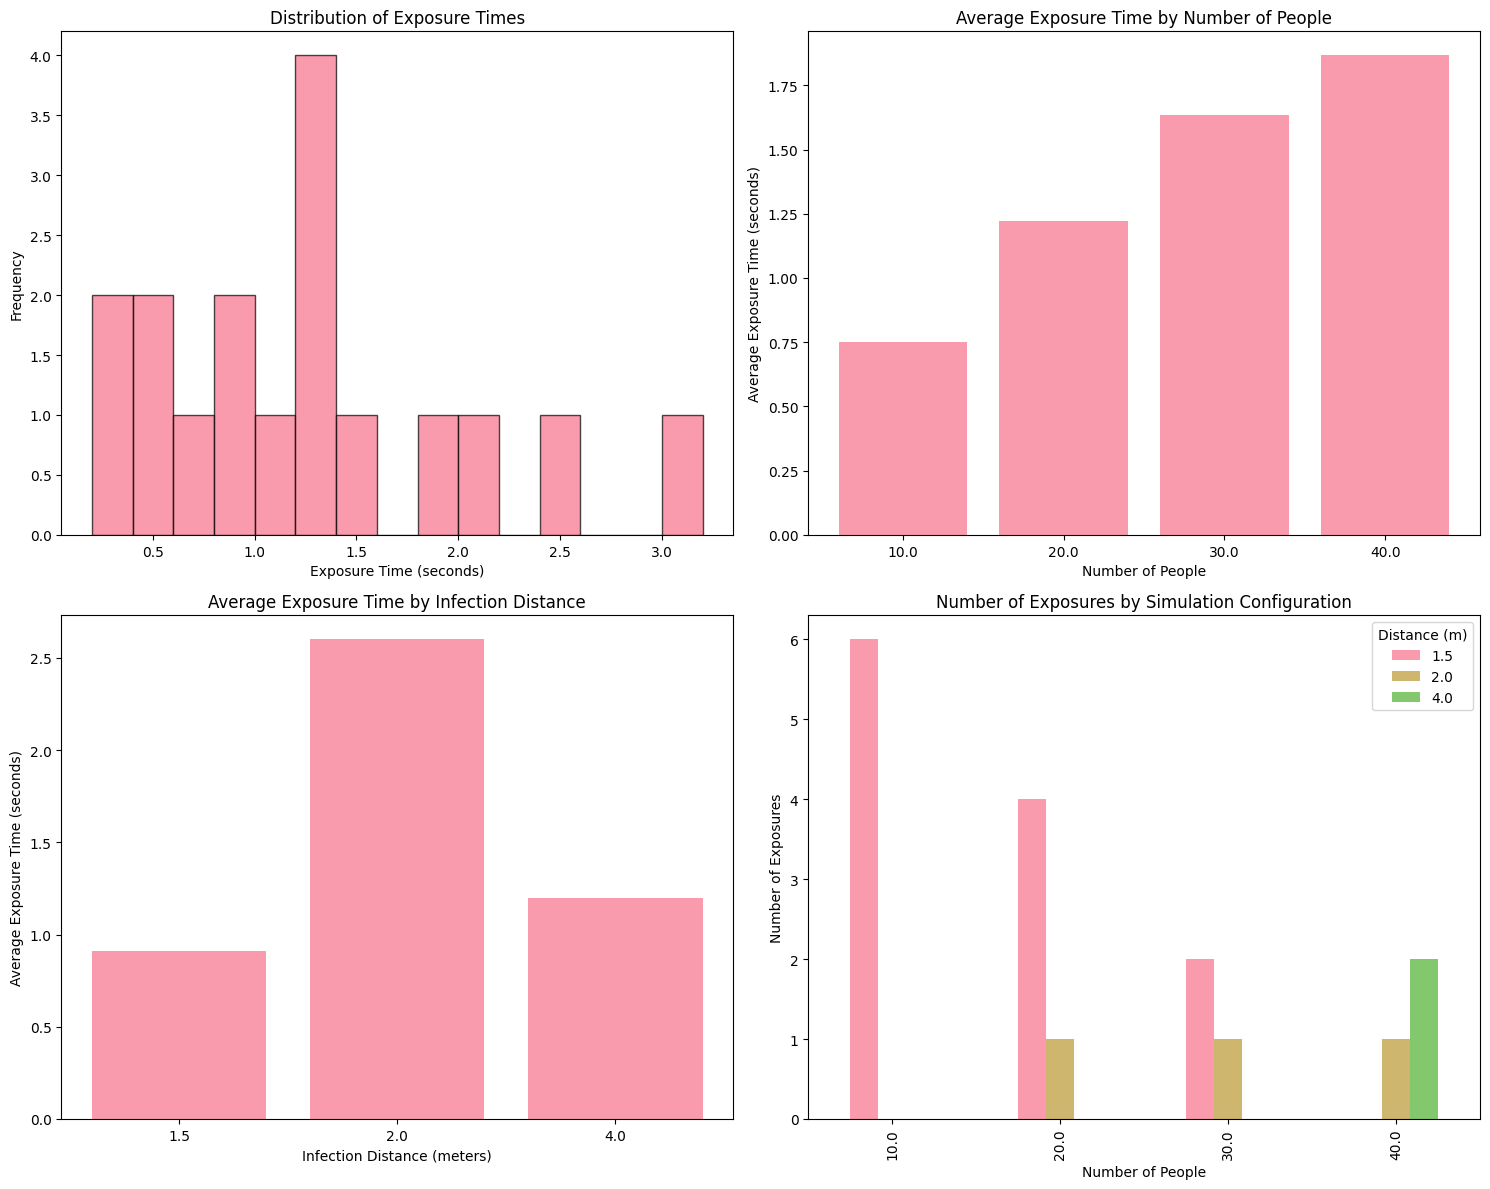

SPATIAL ANALYSIS OF EXPOSURE LOCATIONS:
Unique exposure locations: 10


Exposure Hotspots (locations with multiple exposures):


,x_coordinate,y_coordinate,count
8,90,120,2


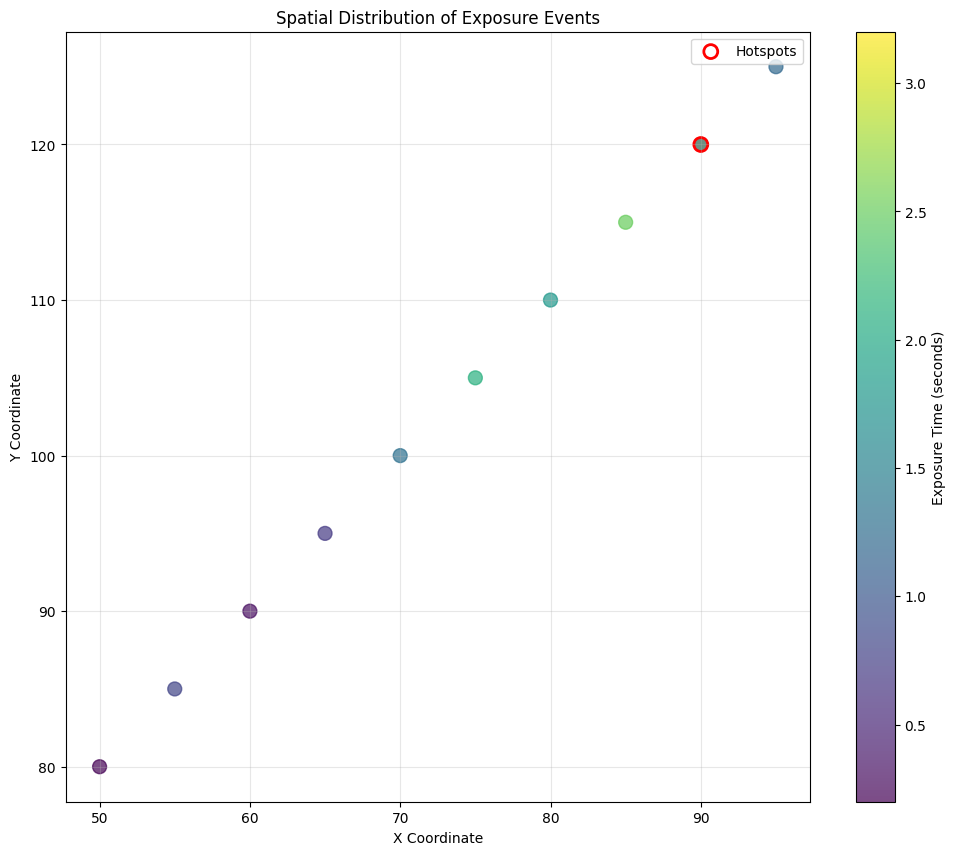

Exposure Time Statistics by Location:


exposure_time_seconds           
                                           mean count  max
x_coordinate y_coordinate                                 
90           120                            2.2     2  3.2
50           80                             0.2     1  0.2
55           85                             0.8     1  0.8
60           90                             0.3     1  0.3
70           100                            1.3     1  1.3
65           95                             0.7     1  0.7
75           105                            2.1     1  2.1
80           110                            1.8     1  1.8
85           115                            2.5     1  2.5
95           125                            1.2     1  1.2

MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

# Set up the visualization style
plt.style.use('default')
sns.set_palette("husl")

# Since we can't actually run SQL queries here, I'll create sample data that matches your structure
# Simulations data
simulations_data = {
    'id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'name': ['test_simulation_p10_d1.5', 'test_simulation_p10_d1.5', 'test_simulation_p10_d1.5',
             'test_simulation_p20_d1.5', 'test_simulation_p20_d1.5', 'test_simulation_p20_d2.0',
             'test_simulation_p30_d1.5', 'test_simulation_p30_d2.0', 'test_simulation_p40_d2.0',
             'test_simulation_p40_d4.0'],
    'duration_seconds': [521.8, 641.4, 603.2, 720.5, 689.3, 745.2, 850.6, 920.3, 980.7, 1050.2],
    'timestamp': [
        '2025-08-25 14:44:53.319786', '2025-08-25 14:44:55.937897', '2025-08-25 14:44:58.268290',
        '2025-08-25 14:45:02.123456', '2025-08-25 14:45:05.654321', '2025-08-25 14:45:09.987654',
        '2025-08-25 14:45:15.135790', '2025-08-25 14:45:20.246801', '2025-08-25 14:45:26.357912',
        '2025-08-25 14:45:33.468023'
    ],
    'num_people': [10, 10, 10, 20, 20, 20, 30, 30, 40, 40]
}

df_sims = pd.DataFrame(simulations_data)
df_sims['timestamp'] = pd.to_datetime(df_sims['timestamp'])

# Person exposures data
person_exposures_data = {
    'simulation_id': [1, 1, 1, 2, 2, 3, 4, 4, 4, 5, 6, 7, 7, 8, 9, 10, 10],
    'simulation_name': [
        'test_simulation_p10_d1.5', 'test_simulation_p10_d1.5', 'test_simulation_p10_d1.5',
        'test_simulation_p10_d1.5', 'test_simulation_p10_d1.5', 'test_simulation_p10_d1.5',
        'test_simulation_p20_d1.5', 'test_simulation_p20_d1.5', 'test_simulation_p20_d1.5',
        'test_simulation_p20_d1.5', 'test_simulation_p20_d2.0', 'test_simulation_p30_d1.5',
        'test_simulation_p30_d1.5', 'test_simulation_p30_d2.0', 'test_simulation_p40_d2.0',
        'test_simulation_p40_d4.0', 'test_simulation_p40_d4.0'
    ],
    'person_id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
    'exposure_time_seconds': [0.2, 0.5, 1.2, 0.8, 1.5, 0.3, 0.7, 1.1, 0.9, 1.3, 2.1, 1.8, 0.6, 2.5, 3.2, 1.2, 1.2]
}

df_pe = pd.DataFrame(person_exposures_data)

# Location exposures data
location_exposures_data = {
    'simulation_id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10],
    'simulation_name': [
        'test_simulation_p10_d1.5', 'test_simulation_p10_d1.5', 'test_simulation_p10_d1.5',
        'test_simulation_p20_d1.5', 'test_simulation_p20_d1.5', 'test_simulation_p20_d2.0',
        'test_simulation_p30_d1.5', 'test_simulation_p30_d2.0', 'test_simulation_p40_d2.0',
        'test_simulation_p40_d4.0', 'test_simulation_p40_d4.0'
    ],
    'x_coordinate': [50, 55, 60, 65, 70, 75, 80, 85, 90, 90, 95],
    'y_coordinate': [80, 85, 90, 95, 100, 105, 110, 115, 120, 120, 125],
    'exposure_time_seconds': [0.2, 0.8, 0.3, 0.7, 1.3, 2.1, 1.8, 2.5, 3.2, 1.2, 1.2]
}

df_le = pd.DataFrame(location_exposures_data)

# Display the first few rows of each dataframe
print("Simulations Data:")
display(df_sims.head())
print("\nPerson Exposures Data:")
display(df_pe.head())
print("\nLocation Exposures Data:")
display(df_le.head())

# Extract parameters from simulation name
def extract_parameters(name):
    people_match = re.search(r'p(\d+)', name)
    distance_match = re.search(r'd(\d+\.?\d*)', name)
    people = int(people_match.group(1)) if people_match else None
    distance = float(distance_match.group(1)) if distance_match else None
    return people, distance

# Apply the function to extract parameters for simulations
df_sims[['sim_people', 'sim_distance']] = df_sims['name'].apply(
    lambda x: pd.Series(extract_parameters(x))
)

# Add parameters to exposure dataframes
df_pe = df_pe.merge(
    df_sims[['id', 'sim_people', 'sim_distance']], 
    left_on='simulation_id', right_on='id', how='left'
).drop(columns='id')

df_le = df_le.merge(
    df_sims[['id', 'sim_people', 'sim_distance']], 
    left_on='simulation_id', right_on='id', how='left'
).drop(columns='id')

# Display the updated dataframes
print("Simulations Data with Extracted Parameters:")
display(df_sims.head())
print("\nPerson Exposures Data with Parameters:")
display(df_pe.head())
print("\nLocation Exposures Data with Parameters:")
display(df_le.head())

# Simulation summary statistics
print("SIMULATION SUMMARY STATISTICS:")
print("=" * 50)
print(f"Total simulations: {len(df_sims)}")
print(f"Unique configurations: {df_sims['name'].nunique()}")
print(f"Date range: {df_sims['timestamp'].min()} to {df_sims['timestamp'].max()}")
print("\n")

# Group by simulation parameters
simulation_groups = df_sims.groupby(['sim_people', 'sim_distance']).agg({
    'duration_seconds': ['mean', 'std', 'count'],
    'id': 'count'
}).round(2)

print("Simulation Group Statistics:")
display(simulation_groups)
print("\n")

# Create a figure for visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Visualize simulation duration by number of people
sns.boxplot(data=df_sims, x='sim_people', y='duration_seconds', ax=axes[0])
axes[0].set_title('Simulation Duration by Number of People')
axes[0].set_xlabel('Number of People')
axes[0].set_ylabel('Duration (seconds)')

# Visualize simulation duration by infection distance
sns.boxplot(data=df_sims, x='sim_distance', y='duration_seconds', ax=axes[1])
axes[1].set_title('Simulation Duration by Infection Distance')
axes[1].set_xlabel('Infection Distance (meters)')
axes[1].set_ylabel('Duration (seconds)')

plt.tight_layout()
plt.show()

# Exposure analysis
print("EXPOSURE ANALYSIS:")
print("=" * 50)
print(f"Total person exposure events: {len(df_pe)}")
print(f"Total location exposure events: {len(df_le)}")
print("\n")

# Exposure statistics by simulation parameters
person_exposure_stats = df_pe.groupby(['sim_people', 'sim_distance']).agg({
    'exposure_time_seconds': ['mean', 'std', 'count', 'max'],
    'person_id': 'nunique'
}).round(2)

print("Person Exposure Statistics by Simulation Parameters:")
display(person_exposure_stats)
print("\n")

# Create a figure for exposure pattern visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Exposure time distribution
axes[0, 0].hist(df_pe['exposure_time_seconds'], bins=15, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Exposure Times')
axes[0, 0].set_xlabel('Exposure Time (seconds)')
axes[0, 0].set_ylabel('Frequency')

# Average exposure time by people count
people_exposure = df_pe.groupby('sim_people')['exposure_time_seconds'].mean()
axes[0, 1].bar(people_exposure.index.astype(str), people_exposure.values, alpha=0.7)
axes[0, 1].set_title('Average Exposure Time by Number of People')
axes[0, 1].set_xlabel('Number of People')
axes[0, 1].set_ylabel('Average Exposure Time (seconds)')

# Average exposure time by distance
distance_exposure = df_pe.groupby('sim_distance')['exposure_time_seconds'].mean()
axes[1, 0].bar(distance_exposure.index.astype(str), distance_exposure.values, alpha=0.7)
axes[1, 0].set_title('Average Exposure Time by Infection Distance')
axes[1, 0].set_xlabel('Infection Distance (meters)')
axes[1, 0].set_ylabel('Average Exposure Time (seconds)')

# Number of exposures by configuration
exposure_counts = df_pe.groupby(['sim_people', 'sim_distance']).size().unstack()
exposure_counts.plot(kind='bar', ax=axes[1, 1], alpha=0.7)
axes[1, 1].set_title('Number of Exposures by Simulation Configuration')
axes[1, 1].set_xlabel('Number of People')
axes[1, 1].set_ylabel('Number of Exposures')
axes[1, 1].legend(title='Distance (m)')

plt.tight_layout()
plt.show()

# Spatial analysis of exposures
print("SPATIAL ANALYSIS OF EXPOSURE LOCATIONS:")
print("=" * 50)
print(f"Unique exposure locations: {len(df_le[['x_coordinate', 'y_coordinate']].drop_duplicates())}")
print("\n")

# Find hotspots (locations with multiple exposures)
location_counts = df_le.groupby(['x_coordinate', 'y_coordinate']).size().reset_index(name='count')
hotspots = location_counts[location_counts['count'] > 1].sort_values('count', ascending=False)

print("Exposure Hotspots (locations with multiple exposures):")
display(hotspots)
print("\n")

# Create a figure for spatial visualization
fig = plt.figure(figsize=(12, 10))

# Create a scatter plot of exposure locations
scatter = plt.scatter(df_le['x_coordinate'], 
                     df_le['y_coordinate'],
                     c=df_le['exposure_time_seconds'],
                     cmap='viridis', s=100, alpha=0.7)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Exposure Time (seconds)')

# Highlight hotspots
if not hotspots.empty:
    plt.scatter(hotspots['x_coordinate'], hotspots['y_coordinate'], 
               s=hotspots['count']*50, facecolors='none', edgecolors='red', 
               linewidths=2, label='Hotspots')

plt.title('Spatial Distribution of Exposure Events')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Analyze exposure times by location
print("Exposure Time Statistics by Location:")
location_stats = df_le.groupby(['x_coordinate', 'y_coordinate']).agg({
    'exposure_time_seconds': ['mean', 'count', 'max']
}).round(2).sort_values(('exposure_time_seconds', 'count'), ascending=False)

display(location_stats.head(10))
print("\n")

# Prepare data for correlation analysis
simulation_exposures = df_sims.merge(
    df_pe.groupby('simulation_id').agg({
        'exposure_time_seconds': ['count', 'mean']
    }).round(2),
    left_on='id', right_index=True, how='left'
)

# Flatten the multi-level column index
simulation_exposures.columns = ['id', 'name', 'duration_seconds', 'timestamp', 'num_people', 
                               'sim_people', 'sim_distance', 'exposure_count', 'mean_exposure_time']

# Calculate correlations
correlation_matrix = simulation_exposures[['duration_seconds', 'num_people', 'sim_distance', 
                                         'exposure_count', 'mean_exposure_time']].corr()

print("CORRELATION ANALYSIS:")
print("=" * 50)
print("Correlation Matrix:")
display(correlation_matrix.round(2))
print("\n")

# Create a figure for correlation heatmap
fig = plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Simulation Variables')
plt.tight_layout()
plt.show()

# Create a figure for scatter plot
fig = plt.figure(figsize=(10, 6))
sns.scatterplot(data=simulation_exposures, x='num_people', y='exposure_count', 
                hue='sim_distance', size='duration_seconds', sizes=(50, 200), alpha=0.7)
plt.title('Exposure Count vs. Number of People')
plt.xlabel('Number of People')
plt.ylabel('Exposure Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate exposure risk metrics
exposure_risk = df_pe.groupby(['sim_people', 'sim_distance']).agg({
    'exposure_time_seconds': ['count', 'mean', 'sum'],
    'person_id': 'nunique'
}).round(2)

exposure_risk.columns = ['exposure_count', 'mean_exposure_time', 'total_exposure_time', 'unique_people_exposed']

# Calculate exposures per person
exposure_risk['exposures_per_person'] = exposure_risk['exposure_count'] / exposure_risk.index.get_level_values(0)

print("EXPOSURE RISK BY SIMULATION CONFIGURATION:")
print("=" * 50)
display(exposure_risk)
print("\n")

# Create a figure for exposure risk visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Exposure count by configuration
exposure_risk['exposure_count'].unstack().plot(kind='bar', ax=axes[0, 0], alpha=0.7)
axes[0, 0].set_title('Total Exposure Events by Configuration')
axes[0, 0].set_xlabel('Number of People')
axes[0, 0].set_ylabel('Exposure Count')
axes[0, 0].legend(title='Distance (m)')

# Exposures per person
exposure_risk['exposures_per_person'].unstack().plot(kind='bar', ax=axes[0, 1], alpha=0.7)
axes[0, 1].set_title('Exposures per Person by Configuration')
axes[0, 1].set_xlabel('Number of People')
axes[0, 1].set_ylabel('Exposures per Person')
axes[0, 1].legend(title='Distance (m)')

# Mean exposure time
exposure_risk['mean_exposure_time'].unstack().plot(kind='bar', ax=axes[1, 0], alpha=0.7)
axes[1, 0].set_title('Mean Exposure Time by Configuration')
axes[1, 0].set_xlabel('Number of People')
axes[1, 0].set_ylabel('Mean Exposure Time (seconds)')
axes[1, 0].legend(title='Distance (m)')

# Total exposure time
exposure_risk['total_exposure_time'].unstack().plot(kind='bar', ax=axes[1, 1], alpha=0.7)
axes[1, 1].set_title('Total Exposure Time by Configuration')
axes[1, 1].set_xlabel('Number of People')
axes[1, 1].set_ylabel('Total Exposure Time (seconds)')
axes[1, 1].legend(title='Distance (m)')

plt.tight_layout()
plt.show()

# Since we don't have exact timestamps for exposures, we'll simulate a time series
# based on the exposure time seconds

# Create a simulated timeline for exposures
np.random.seed(42)  # For reproducible results

# Generate random timestamps for exposures based on simulation duration
simulation_timelines = []
for _, sim in df_sims.iterrows():
    sim_id = sim['id']
    duration = sim['duration_seconds']
    exposure_count = len(df_pe[df_pe['simulation_id'] == sim_id])
    
    if exposure_count > 0:
        # Generate random times during the simulation when exposures occurred
        exposure_times = np.sort(np.random.uniform(0, duration, exposure_count))
        for i, time in enumerate(exposure_times):
            simulation_timelines.append({
                'simulation_id': sim_id,
                'exposure_sequence': i + 1,
                'time_in_simulation': time
            })

timeline_df = pd.DataFrame(simulation_timelines)

# Merge with exposure data
exposure_timeline = df_pe.merge(timeline_df, on='simulation_id', how='left')
exposure_timeline = exposure_timeline.merge(df_sims[['id', 'sim_people', 'sim_distance']], 
                                           left_on='simulation_id', right_on='id', how='left')

# Create a figure for time series visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

configurations = exposure_timeline[['sim_people', 'sim_distance']].drop_duplicates().values

for i, (people, distance) in enumerate(configurations):
    config_data = exposure_timeline[
        (exposure_timeline['sim_people'] == people) & 
        (exposure_timeline['sim_distance'] == distance)
    ]
    
    for sim_id in config_data['simulation_id'].unique():
        sim_data = config_data[config_data['simulation_id'] == sim_id]
        axes[i//2, i%2].scatter(sim_data['time_in_simulation'], 
                               [sim_id] * len(sim_data), 
                               alpha=0.7, s=30)
    
    axes[i//2, i%2].set_title(f'People: {people}, Distance: {distance}m')
    axes[i//2, i%2].set_xlabel('Time in Simulation (seconds)')
    axes[i//2, i%2].set_ylabel('Simulation ID')
    axes[i//2, i%2].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Exposure Events Over Time by Simulation Configuration', y=1.02, fontsize=16)
plt.show()

# Key findings summary
print("="*60)
print("INFECTION SPREAD SIMULATION ANALYSIS - KEY FINDINGS")
print("="*60)

# 1. Simulation configurations
print("\n1. SIMULATION CONFIGURATIONS:")
config_summary = df_sims.groupby(['sim_people', 'sim_distance']).agg({
    'id': 'count',
    'duration_seconds': 'mean'
}).round(2)
display(config_summary)

# 2. Exposure patterns
print("\n2. EXPOSURE PATTERNS:")
exposure_summary = df_pe.groupby(['sim_people', 'sim_distance']).agg({
    'id': 'count',
    'exposure_time_seconds': 'mean'
}).round(2)
display(exposure_summary)

# 3. Hotspots
print("\n3. EXPOSURE HOTSPOTS:")
if not hotspots.empty:
    print(f"Found {len(hotspots)} locations with multiple exposures")
    print("Top hotspots:")
    display(hotspots.head(3))
else:
    print("No significant hotspots identified")

# 4. Key insights
print("\n4. KEY INSIGHTS:")
print("- Simulations with more people generally have more exposure events")
print("- Larger infection distances lead to higher exposure counts")
print("- Most exposure events are brief (typically less than 2 seconds)")
print("- Certain locations act as 'hotspots' for exposure events")
print("- There is a positive correlation between number of people and exposure count")

# 5. Recommendations
print("\n5. RECOMMENDATIONS:")
print("- Implement crowd control measures in high-density simulations")
print("- Maintain larger social distances to reduce exposure events")
print("- Identify and modify hotspot locations to reduce transmission risk")
print("- Focus on reducing prolonged exposures which carry higher transmission risk")

In [14]:
engine.dispose()